# Intro
This notebook calculates the discovery potential of nEXO assuming that nEXO operates as counting experiment, i.e. how many background events vs signal events there are in the ROI instead of our standard multi-dimensional binned maximum log-likelihood fit. 

# Packages and Setup

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import scipy.stats as st
import gammapy.stats as gstats
import ROOT

Welcome to JupyROOT 6.22/02


In [3]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['font.family'] = 'serif'

In [4]:
colors = ['#1f78b4', '#e66101', '#33a02c', '#984ea3', 'grey', 
          'k', '#F27781', '#18298C', '#04BF8A', '#F2CF1D', 
          '#F29F05', '#7155D9', '#8D07F6', '#9E91F2', '#F29B9B', 
          '#F25764', '#6FB7BF', '#B6ECF2', '#5D1314', '#B3640F', 
         '#1f78b4', '#e66101', '#33a02c', '#984ea3', 'grey', 
          'k', '#F27781', '#18298C', '#04BF8A', '#F2CF1D', 
          '#F29F05', '#7155D9', '#8D07F6', '#9E91F2', '#F29B9B', 
          '#F25764', '#6FB7BF', '#B6ECF2', '#5D1314', '#B3640F']

# Parameters

In [5]:
XenonMass = [500.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3281.0] # in kg 
BkgIndexRaw = [0.000132, 0.000218, 0.000316, 0.000497, 0.000743, 0.0012, 0.00158] # in cts/FWHM/kg/yr 
BkgIndexRaw = [3.2e-05, 5.36e-05, 0.000118, 0.000183, 0.000335, 0.000509, 0.000729] # in cts/FWHM/kg/yr 

# XenonMass = [500.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3873.0]
# BkgIndexRaw = [0.000106, 0.000138, 0.000208, 0.000354, 0.000564, 0.000854, 0.00188] # in cts/FWHM/kg/yr 

BkgIndex = {}
for ii,Mass in enumerate(XenonMass): 
    BkgIndex[Mass] = BkgIndexRaw[ii]*2.0
                       
Livetime = np.append(np.arange(0.1,1,0.1), np.arange(1,10.1,0.5)) # in yrs

Bb0nEfficiency = 0.5741

# Functions

In [6]:
mmass_xe136 = 135.907214 # in g/mol 
mmass_xe134 = 133.905393 # in g/mol 
Avogadro = 6.022E23 # in 1/mol
frac_136 = 0.9
frac_134 = 0.1

def GetNumberOfXeAtoms(XenonMass): 
    return XenonMass*1000.0*frac_136 / (frac_136*mmass_xe136 + frac_134*mmass_xe134) * Avogadro

In [7]:
def GetNumberOfSignals(Halflife, Efficiency, NXenonAtoms, Livetime): 
    return Efficiency * NXenonAtoms * Livetime * np.log(2) / Halflife

In [8]:
def GetHalflifeFromSignalCount(Signal, Efficiency, NXenonAtoms, Livetime): 
    return Efficiency * NXenonAtoms * Livetime * np.log(2) / Signal

In [9]:
def GetBkgCounts(BkgIndex, XenonMass, Livetime): 
    BkgCounts = BkgIndex * XenonMass * Livetime
    return BkgCounts

In [10]:
def Get90CLSensitivity(Background): 
    x_bins = np.arange(0, 500)
    mu_bins = np.linspace(0, 50, int(50/1), endpoint=True)
    matrix = [st.poisson(mu + Background).pmf(x_bins) for mu in mu_bins]
    acceptance_intervals = gstats.fc_construct_acceptance_intervals_pdfs(matrix, 0.9)
    LowerLimitNum, UpperLimitNum, _ = gstats.fc_get_limits(mu_bins, x_bins, acceptance_intervals)
    sens = gstats.fc_find_average_upper_limit(x_bins, matrix, UpperLimitNum, mu_bins)
    return sens

In [11]:
def GetMedianSignificance(Background, Signal):
    PVal = st.poisson.cdf(Signal, mu=Background)
    return st.norm.ppf(1-PVal)

In [12]:
def GetSignificanceCowan(Background, Signal): 
    return np.sqrt(2 * ( (Signal+Background) * np.log((1+Signal/Background)) - Signal ))

In [13]:
def GetSignificanceCowanBackground(B, S, Error): 
    E = Error * B
    FirstLog = ((S + B)*(B + E**2))/(B**2 + (S+B)*E**2)
    SecondLog = 1 + ((E**2 * S)/(B*(B+E**2)))
    Full = 2 * ((S+B) * np.log(FirstLog) - (B**2/E**2) * np.log(SecondLog) )
    return np.sqrt(Full)

In [14]:
def GetFCUpperLimit(CL, Background, Efficiency): 
    fc = ROOT.TFeldmanCousins(CL)
    fc.SetMuMin(0)
    fc.SetMuMax(200) #(10*mean,10)[mean < 1])
    fc.SetMuStep(0.005)
    result = {}
    
    mean = Background
    signal = 0
    obs = 0
    diff = 1
    while diff > 0.01 or obs < mean:
        prev = signal
        fcul = fc.CalculateUpperLimit(obs,mean)
        pmo = ROOT.TMath.PoissonI(obs,mean)
        signal += pmo * fcul
        diff = signal - prev
        obs += 1
    return signal

# Calculations

Let's define the range over which we want to test different signal hypothesis. Here we choose a fine binning for average number of signal events 

In [15]:
SignalRange = np.arange(0.01,1,0.01)
SignalRange = np.append(SignalRange[:-1], np.arange(1,50,0.2))

In [16]:
Background = {}
Signal = {}
SignalRange = np.arange(0.01,1,0.01)
SignalRange = np.append(SignalRange[:-1], np.arange(1,50,0.2))
for ii,Mass in enumerate(XenonMass): 
    print('-'*20)
    print('Running fiducial mass of %d kg' % Mass)
    
    Background[ii] = {} 
    Signal[ii] = {} 
    
    for jj,Time in enumerate(Livetime): 
        Background[ii][jj] = {} 
        Signal[ii][jj] = {} 
        
        Background[ii][jj] = GetBkgCounts(BkgIndex[Mass], Mass, Time)
        
        Signal[ii][jj]['Counts'] = []
        Signal[ii][jj]['Significance'] = []
        Signal[ii][jj]['SignificanceNoBackground'] = []
        Signal[ii][jj]['SignificanceWithBackground'] = []
        
        for kk,Counts in enumerate(SignalRange):    
            Median = st.poisson.median(mu=(Background[ii][jj]+Counts))
            Sigma = GetMedianSignificance(Background=Background[ii][jj], Signal=Median)

            Signal[ii][jj]['Counts'].append(Counts)
            Signal[ii][jj]['Significance'].append(np.abs(Sigma))
            Signal[ii][jj]['SignificanceNoBackground'].append(GetSignificanceCowan(Background[ii][jj], Counts))
            Signal[ii][jj]['SignificanceWithBackground'].append(GetSignificanceCowanBackground(Background[ii][jj], Counts, 0.1))

--------------------
Running fiducial mass of 500 kg
--------------------
Running fiducial mass of 1000 kg
--------------------
Running fiducial mass of 1500 kg
--------------------
Running fiducial mass of 2000 kg
--------------------
Running fiducial mass of 2500 kg
--------------------
Running fiducial mass of 3000 kg
--------------------
Running fiducial mass of 3281 kg


Running fiducial mass of 500 kg
Running fiducial mass of 1000 kg
Running fiducial mass of 1500 kg
Running fiducial mass of 2000 kg
Running fiducial mass of 2500 kg
Running fiducial mass of 3000 kg
Running fiducial mass of 3281 kg


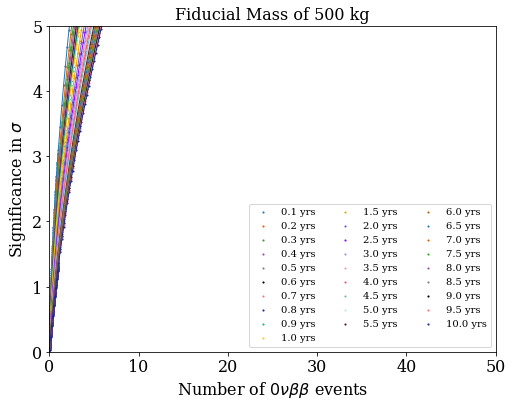

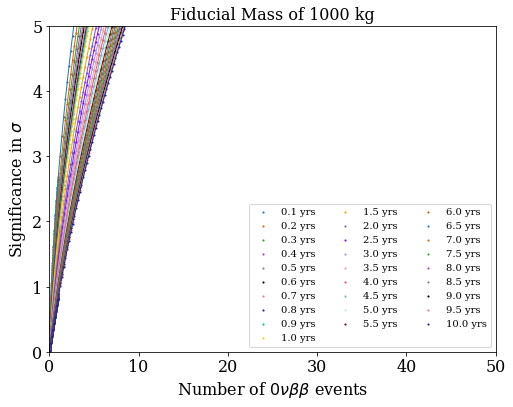

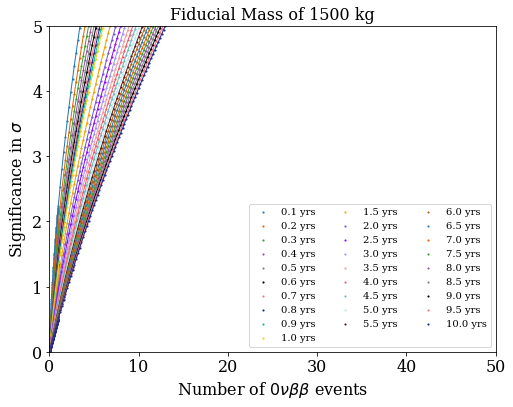

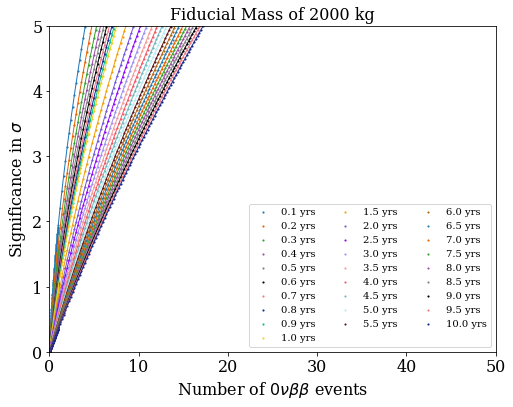

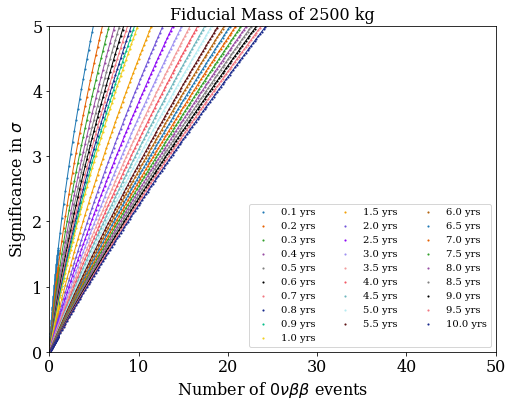

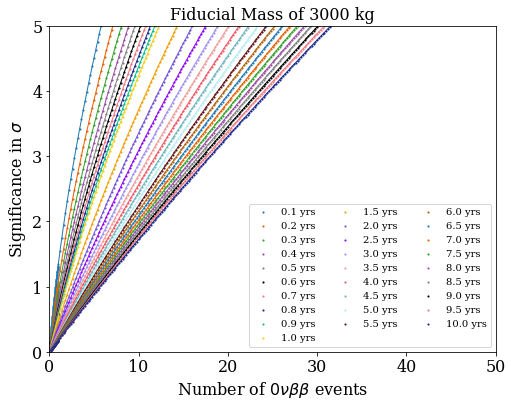

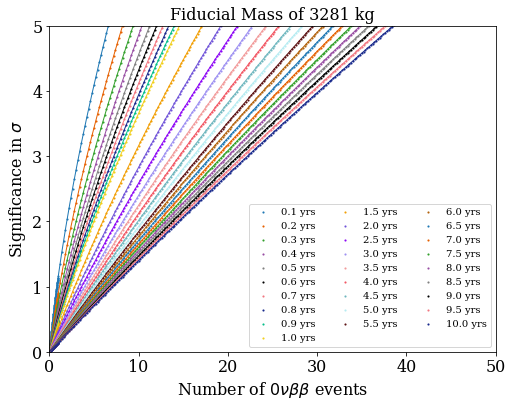

In [20]:
Halflife = {}

for ii,Mass in enumerate(XenonMass):  
    print('Running fiducial mass of %d kg' % Mass)
    Halflife[Mass] = {}
    Halflife[Mass]['3sigma'] = []
    Halflife[Mass]['90CL'] = []
    
    plt.figure(figsize=(8,6))
    plt.xlabel(r'Number of $0\nu\beta\beta$ events')
    plt.ylabel(r'Significance in $\sigma$')
    for jj,Time in enumerate(Livetime): 
        
        plt.scatter(Signal[ii][jj]['Counts'], Signal[ii][jj]['SignificanceNoBackground'], label='%.1f yrs' % Time, color = colors[jj], s=5, marker='.')
        LinearCut = np.where(np.array(Signal[ii][jj]['SignificanceNoBackground'])<100)[0][-1]
        XInterp = np.linspace(np.min(Signal[ii][jj]['Counts']),Signal[ii][jj]['Counts'][LinearCut],1000)

        Interpolation = np.interp(XInterp, Signal[ii][jj]['Counts'][:LinearCut+1], Signal[ii][jj]['SignificanceNoBackground'][:LinearCut+1])
        Diff1 = np.abs(Interpolation - 3.0)
        Cut1 = np.where(Diff1 == np.min(Diff1))[0][0]
        
        Diff2 = np.abs(Interpolation - st.norm.ppf(0.9))
        Cut2 = np.where(Diff2 == np.min(Diff2))[0][0]
        
#         Sensitivity = Get90CLSensitivity(Background[ii][jj])
        Sensitivity = GetFCUpperLimit(0.9, Background[ii][jj], Bb0nEfficiency)
        Discovery = GetFCUpperLimit(st.norm.cdf(3), Background[ii][jj], Bb0nEfficiency)
#         print(Sensitivity)
        
        plt.plot(XInterp,Interpolation, ls='-', color=colors[jj])
        
#         Halflife[Mass]['3sigma'].append(GetHalflifeFromSignalCount(XInterp[Cut1], Bb0nEfficiency, GetNumberOfXeAtoms(Mass), Time))
        Halflife[Mass]['3sigma'].append(GetHalflifeFromSignalCount(Discovery, Bb0nEfficiency, GetNumberOfXeAtoms(Mass), Time))
        Halflife[Mass]['90CL'].append(GetHalflifeFromSignalCount(Sensitivity, Bb0nEfficiency, GetNumberOfXeAtoms(Mass), Time))
        
    plt.xlim(0,50.0)
    plt.ylim(0,5)
    plt.title('Fiducial Mass of %d kg' % Mass, fontsize=16)
    plt.legend(loc='lower right', fontsize=10, ncol=3)
    plt.savefig('significance_%dkg_%dyrs.pdf' % (Mass,Time), bbox_inches='tight')

# Importing data from previous sensitivity paper

In [18]:
import pandas as pd
discovery2017 = pd.read_csv('2017_discovery_potential.csv',  header=None, usecols=[0,1])
sensitivity2017 = pd.read_csv('2017_sensitivity.csv',  header=None, usecols=[0,1])
livetime = [1.0, 2.0, 5.0,10.0]
discovery = [1.0452531540965649e+27, 1.6586825705804897e+27, 3.3579337802678305e+27, 5.026e+27]

livetime = [0.5, 1.0, 2.0, 5.0, 10.0]
discovery = np.array([0.881, 1.47, 2.32, 4.33, 6.23])*1E27

sensitivity2017 = {}
sensitivity2017['Mass_Likelihood'] = np.array([500,1000,2000,3000,3744])
sensitivity2017['Mass_Counting'] = np.array([500,1000,1500,2000,2500,3000,3744])
sensitivity2017['Likelihood_vs_Mass'] = np.array([5.48, 7.23, 8.63, 9.15, 9.22])*1E27
sensitivity2017['Counting_vs_Mass'] = np.array([2.985, 4.697, 5.597, 5.869, 5.714, 5.260, 4.208])*1E27
sensitivity2017['Likelihood_vs_Livetime'] = pd.read_csv('2017_sensitivity.csv',  header=None, usecols=[0,1])

sensitivity = {}
sensitivity['Livetime'] = np.array([0.5, 1, 2, 5, 10])
sensitivity['Halflife'] = np.array([1.344, 2.157, 3.297, 5.824, 8.780])*1E27
sensitivity['Halflife'] = np.array([1.648, 2.818, 4.538, 8.400, 12.85])*1E27

# Plotting results

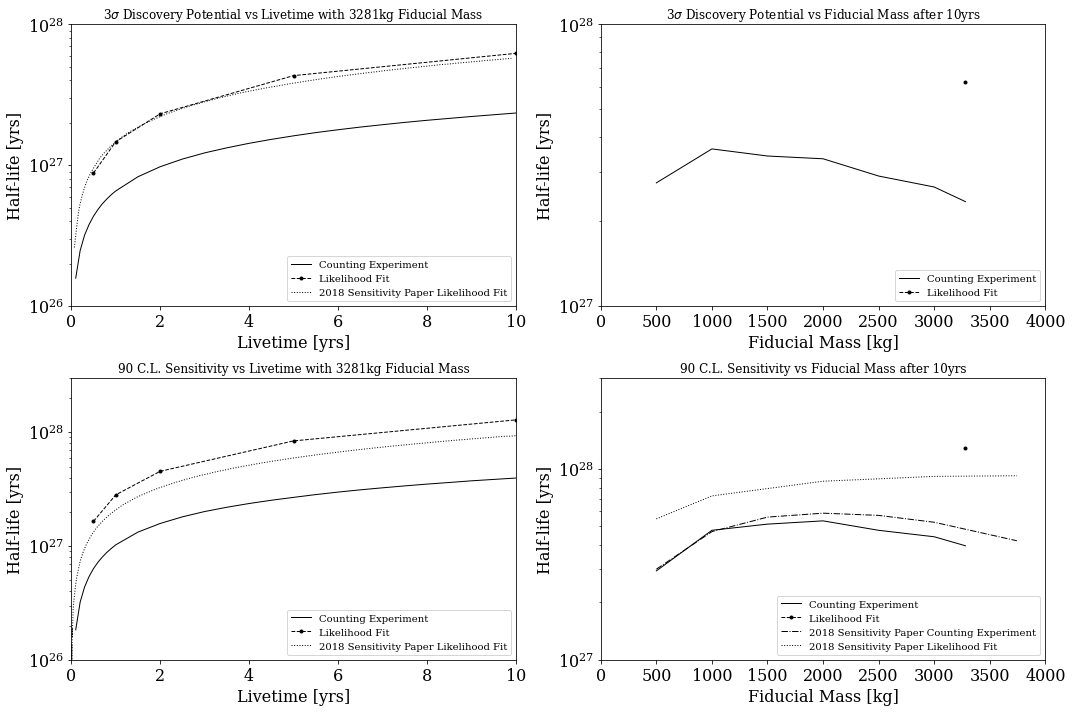

In [19]:
fig, ax = plt.subplots (2, 2, figsize=(15, 10), gridspec_kw=dict(width_ratios=(1,1)))

ax[0,0].set_xlim(0,10)
ax[0,0].set_ylim(1E26,1E28)
ax[0,0].set_xlabel(r'Livetime [yrs]')
ax[0,0].set_ylabel(r'Half-life [yrs]')
ax[0,0].set_yscale('log')
ax[0,0].set_title(r'3$\sigma$ Discovery Potential vs Livetime with 3281kg Fiducial Mass')
ax[0,0].plot(Livetime, Halflife[XenonMass[-1]]['3sigma'], label=r'Counting Experiment', color='k')
ax[0,0].plot(livetime, discovery, label='Likelihood Fit', color='k', marker='.', ls='--')
ax[0,0].plot(discovery2017[0], discovery2017[1], label='2018 Sensitivity Paper Likelihood Fit', color='k', ls=':')
ax[0,0].legend(loc='lower right')

ax[0,1].set_xlim(0,4000)
ax[0,1].set_ylim(1E27,1E28)
ax[0,1].set_xlabel(r'Fiducial Mass [kg]')
ax[0,1].set_ylabel(r'Half-life [yrs]')
ax[0,1].set_yscale('log')
ax[0,1].set_title(r'3$\sigma$ Discovery Potential vs Fiducial Mass after 10yrs')
ax[0,1].plot(list(Halflife.keys()), [Halflife[key]['3sigma'][-1] for key in Halflife.keys()], color='k', ls='-', label='Counting Experiment')
ax[0,1].plot(XenonMass[-1], discovery[-1], label='Likelihood Fit', color='k', marker='.', ls='--')
ax[0,1].legend(loc='lower right')

ax[1,0].set_xlim(0,10)
ax[1,0].set_ylim(1E26,3E28)
ax[1,0].set_xlabel(r'Livetime [yrs]')
ax[1,0].set_ylabel(r'Half-life [yrs]')
ax[1,0].set_yscale('log')
ax[1,0].set_title(r'90 C.L. Sensitivity vs Livetime with 3281kg Fiducial Mass')
ax[1,0].plot(Livetime, Halflife[XenonMass[-1]]['90CL'], label=r'Counting Experiment ', color='k')
ax[1,0].plot(sensitivity['Livetime'], sensitivity['Halflife'], label='Likelihood Fit', color='k', marker='.', ls='--')
ax[1,0].plot(sensitivity2017['Likelihood_vs_Livetime'][0], sensitivity2017['Likelihood_vs_Livetime'][1], label='2018 Sensitivity Paper Likelihood Fit', color='k', ls=':')
ax[1,0].legend(loc='lower right')

ax[1,1].set_xlim(0,4000)
ax[1,1].set_ylim(1E27,3E28)
ax[1,1].set_xlabel(r'Fiducial Mass [kg]')
ax[1,1].set_ylabel(r'Half-life [yrs]')
ax[1,1].set_yscale('log')
ax[1,1].set_title(r'90 C.L. Sensitivity vs Fiducial Mass after 10yrs')
ax[1,1].plot(list(Halflife.keys()), [Halflife[key]['90CL'][-1] for key in Halflife.keys()], color='k', ls='-', label='Counting Experiment')
ax[1,1].plot(XenonMass[-1], sensitivity['Halflife'][-1], label='Likelihood Fit', color='k', marker='.', ls='--')
ax[1,1].plot(sensitivity2017['Mass_Counting'], sensitivity2017['Counting_vs_Mass'], color='k', ls='-.', label='2018 Sensitivity Paper Counting Experiment')
ax[1,1].plot(sensitivity2017['Mass_Likelihood'], sensitivity2017['Likelihood_vs_Mass'], color='k', ls=':', label='2018 Sensitivity Paper Likelihood Fit')
ax[1,1].legend(loc='lower right')

fig.tight_layout()
plt.savefig('results_compilation.pdf')